In [1]:
!nvidia-smi

Sun May 12 23:23:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   26C    P8             17W /  230W |     281MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import math
from tqdm.auto import tqdm
from datasets import load_dataset, concatenate_datasets, load_from_disk
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [14]:
class NoiseScheduler(nn.Module):
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        assert beta_start < beta_end < 1.0, "beta1 and beta2 must be in (0, 1)"

        beta = ((beta_end - beta_start) * torch.arange(0, num_timesteps + 1, dtype=torch.float32) / num_timesteps + beta_start).to(device)
        sqrt_beta = torch.sqrt(beta)
        alpha = 1. - beta
        log_alpha = torch.log(alpha)
        alpha_hat = torch.cumsum(log_alpha, dim=0).exp()
        
        one_over_sqrt_alpha = 1 / torch.sqrt(alpha)
        sqrt_alpha_hat = torch.sqrt(alpha_hat)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)

        self.register_buffer("beta", beta)
        self.register_buffer("sqrt_beta", sqrt_beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_hat", alpha_hat)
        self.register_buffer("one_over_sqrt_alpha", one_over_sqrt_alpha)
        self.register_buffer("sqrt_alpha_hat", sqrt_alpha_hat)
        self.register_buffer("sqrt_one_minus_alpha_hat", sqrt_one_minus_alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,))

    def denoise(self, noisy_image, predicted_noise, z, t):
        one_over_sqrt_alpha = self.one_over_sqrt_alpha[t]
        pred_noise_coeff = (1 - self.alpha[t])/self.sqrt_one_minus_alpha_hat[t]
        sqrt_beta = self.sqrt_beta[t]
        return (
                one_over_sqrt_alpha * (noisy_image - (pred_noise_coeff * predicted_noise))
                + sqrt_beta * z
            )

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
           
            if self.in_channels == self.out_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualBlock(out_channels, out_channels),
            ResidualBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.conv(x)
        return x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ClassEmbedding(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes=2, num_features=64):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_features = num_features

        self.init_conv = ResidualBlock(in_channels, num_features, is_res=True)

        self.down_conv1 = DownBlock(num_features, num_features)
        self.down_conv2 = DownBlock(num_features, 2 * num_features)

        self.mid_block = nn.Sequential(
            nn.AvgPool2d(7), 
            nn.GELU()
        )

        self.time_embedding1 = SinusoidalPositionEmbeddings(2 * num_features)
        self.time_embedding2 = SinusoidalPositionEmbeddings(num_features)

        self.class_embedding1 = nn.Embedding(num_classes, 2 * num_features)
        self.class_embedding2 = nn.Embedding(num_classes, num_features)
        

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(2 * num_features, 2 * num_features, kernel_size=16, stride=8, padding=4),
            nn.GroupNorm(8, 2 * num_features),
            nn.ReLU(),
        )
    
        self.up_conv1 = UpBlock(4 * num_features, num_features)
        self.up_conv2 = UpBlock(2 * num_features, num_features)
        self.out_conv = nn.Sequential(
            nn.Conv2d(2 * num_features, num_features, 3, 1, 1),
            nn.GroupNorm(8, num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, self.in_channels, 3, 1, 1)
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1_out = self.down_conv1(x)
        down2_out = self.down_conv2(down1_out)
        mid_out = self.mid_block(down2_out)
        
        class_emb1 = self.class_embedding1(c).view(-1, self.num_features * 2, 1, 1) * context_mask[:, None, None, None]
        time_emb1 = self.time_embedding1(t).view(-1, self.num_features * 2, 1, 1)
        class_emb2 = self.class_embedding2(c).view(-1, self.num_features, 1, 1) * context_mask[:, None, None, None]
        time_emb2 = self.time_embedding2(t).view(-1, self.num_features, 1, 1)
        
        upsample_out = self.upsample(mid_out)

        up2_out = self.up_conv1(class_emb1 * upsample_out + time_emb1, down2_out)  
        up3_out = self.up_conv2(class_emb2 * up2_out + time_emb2, down1_out)
        out = self.out_conv(torch.cat((up3_out, x), 1))
        return out


In [16]:
class Diffuser(nn.Module):
    def __init__(
        self,
        unet,
        noise_scheduler,
        num_timesteps,
        num_classes,
        eta=0.,
        drop_prob=0.1
    ):
        super().__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps
        self.num_classes = num_classes
        self.criterion = nn.MSELoss()
        self.eta = eta
        self.noise_scheduler = noise_scheduler
        self.drop_prob = drop_prob

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
    
    def forward(self, x, labels=None):
        timesteps = torch.randint(1, self.num_timesteps + 1, (x.shape[0],)).to(x.device)
        noisy_x, noise = self.noise_scheduler.noise_images(x, timesteps)
        context_mask = torch.bernoulli(torch.zeros_like(labels) + (1 - self.drop_prob)).to(x.device)
        predicted_noise = self.unet(noisy_x, labels, timesteps / self.num_timesteps, context_mask)
        return self.criterion(noise, predicted_noise)
   
    def convert_images_to_class(self, x, labels, size, device, num_steps=None):
        if num_steps is None:
            num_steps = self.num_timesteps
        n_samples = x.shape[0]
        x = x.to(device)
        labels = labels.to(device)
        context_mask = torch.ones_like(labels).to(device)
        for t in tqdm(range(num_steps, 0, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(
                x, 
                labels, 
                torch.tensor(t / self.num_timesteps).to(device).repeat(n_samples, ), 
                context_mask
            )
            x = self.noise_scheduler.denoise(x, predicted_noise, z, t)
        return x


In [17]:
ds_train = load_from_disk("image-data/train")
ds_test = load_from_disk("image-data/test")
summer_train = ds_train.filter(lambda x: x["label"] == 0)
winter_train = ds_train.filter(lambda x: x["label"] == 1)
summer_test = ds_test.filter(lambda x: x["label"] == 0)
winter_test = ds_test.filter(lambda x: x["label"] == 1)

img_size = 128
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [label for label in examples["label"]]
    return {"images": images, "labels": labels}

summer_train.set_transform(transform)
winter_train.set_transform(transform)
summer_test.set_transform(transform)
winter_test.set_transform(transform)
dataset_train = concatenate_datasets([summer_train, winter_train])
dataset_test = concatenate_datasets([summer_test, winter_test])
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=0)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [18]:
plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


Legend: 0 = summer 1 = winter
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


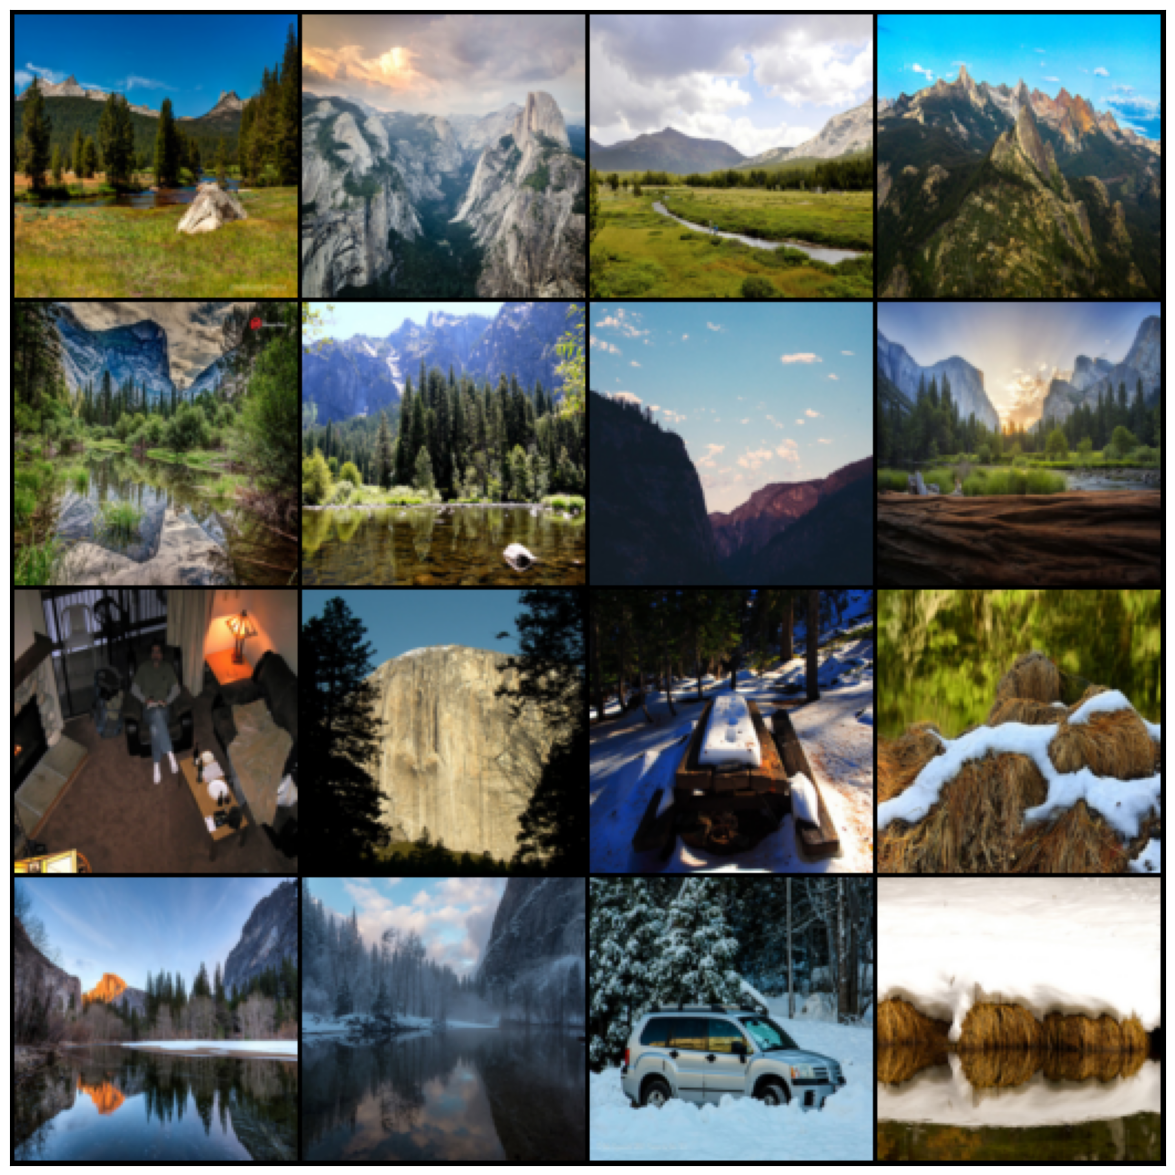

In [19]:
# Set aside some images for evaluation
import random
start_idx = random.randint(0, len(summer_test) - 8 - 1)
summer_images = torch.cat([s.unsqueeze(0) for s in summer_test[start_idx:start_idx + 8]["images"]], dim=0)
winter_images = torch.cat([s.unsqueeze(0) for s in winter_test[start_idx+1:start_idx+1 + 8]["images"]], dim=0)
summer_labels = summer_test[start_idx:start_idx + 8]["labels"]
winter_labels = winter_test[start_idx+1:start_idx+1 + 8]["labels"]
eval_images = torch.cat([summer_images, winter_images], dim=0)
original_eval_labels = torch.Tensor(summer_labels + winter_labels).long()
show(make_grid(eval_images, normalize=True, value_range=(-1, 1), nrow=4))
print("Legend: 0 = summer 1 = winter")
print(f"Labels: {original_eval_labels.tolist()}")

In [20]:
def get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

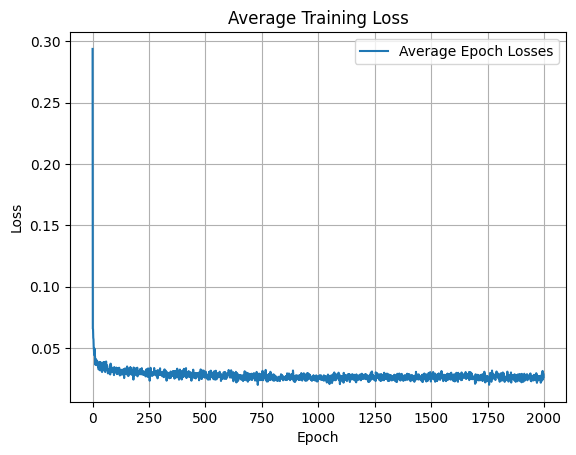

Epoch:   0%|          | 0/999 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/600 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

Training loop:   0%|          | 0/125 [00:00<?, ?it/s]

In [17]:
device = "cuda"
num_epochs = 2000
save_every = 50
num_channels = 3
num_classes = 2
num_timesteps = 600
unet = UNet(num_channels, num_classes).to(device)
scheduler = NoiseScheduler(num_timesteps)
ddpm_model = Diffuser(
    unet,
    scheduler,
    num_timesteps=num_timesteps,
    num_classes=num_classes,
    eta=0.3,
)
ddpm_model.to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

avg_losses = []

fig, ax = plt.subplots()
display_handle = display(fig, display_id=True)

with tqdm(range(num_epochs), desc="Epoch") as ep:
    for epoch in ep:
        ddpm_model.train()
    
        pbar = tqdm(train_dataloader, desc="Training loop", leave=False)
        epoch_losses = [] 
        for batch in pbar:
            optimizer.zero_grad()
            lr = lr_scheduler.get_last_lr()
            x = batch["images"].to(device)
            class_labels = batch["labels"].to(device)
            loss = ddpm_model(x, class_labels)
            loss.backward() 
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 3.0)
            optimizer.step()  
            lr_scheduler.step()
            
            epoch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_losses.append(avg_loss)
        ep.set_postfix(avg_loss=avg_loss, lr=lr)
        
        # Clear the previous plot and plot the updated avg_losses
        ax.clear()
        ax.plot(avg_losses, label="Average Epoch Losses")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Average Training Loss")
        ax.grid(True)
    
        # Redraw the plot
        display_handle.update(fig)

        if epoch % save_every == 0:
            ddpm_model.eval()
            with torch.no_grad():
                noise_steps = 600
                inference_steps = 600
                eval_images = eval_images.to(device)
                convert_to_labels = (1 - original_eval_labels).to(device).long()
                noised_eval_images, _ = ddpm_model.noise_scheduler.noise_images(eval_images, torch.tensor([noise_steps]).to(device))

                samples = ddpm_model.convert_images_to_class(
                    noised_eval_images, 
                    convert_to_labels, 
                    (3, img_size, img_size), 
                    device, 
                    num_steps=inference_steps
                )
                sample_set = torch.cat([samples, eval_images], dim=0)
                grid = make_grid(
                    sample_set, normalize=True, value_range=(-1, 1), nrow=4
                )
                save_image(grid, f"./samples/epoch_{epoch}.png")

                torch.save(ddpm_model.state_dict(), "./models/ddpm_latest.pth")
    
    plt.close()